In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym_environment
env = gym_environment.Environment()

device = torch.device("cpu")
# device = torch.device("cuda")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [3]:
HIDDEN_LAYER_SIZE = 128
class DQN(nn.Module):
	def __init__(self, observation_size, action_size):
		super().__init__()
		# self.fc1 = nn.Linear(observation_size, HIDDEN_LAYER_SIZE)
		# self.fc2 = nn.Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE)
		# self.fc3 = nn.Linear(HIDDEN_LAYER_SIZE, action_size)
		self.fc1 = nn.Linear(observation_size, 32)
		self.fc2 = nn.Linear(32, 64)
		self.fc3 = nn.Linear(64, 128)
		self.fc4 = nn.Linear(128, action_size)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		return self.fc4(x)

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

action_size = env.action_space.n
state, _ = env.reset()
observation_size = len(state)

policy_net = DQN(observation_size, action_size).to(device)
target_net = DQN(observation_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

In [5]:
def select_action(states):
	global steps_done
	sample = random.random()
	eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
	steps_done += 1
	if sample > eps_threshold:
		with torch.no_grad():
			# t.max(1) will return the largest column value of each row.
			# second column on max result is index of where max element was
			# found, so we pick action with the larger expected reward.
			return torch.tensor([policy_net(state).max(1).indices.view(1, 1) for state in states])
	else:
		return torch.tensor([env.action_space.sample() for _ in states], device=device, dtype=torch.long)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import const

def my_optimize_model():
	if len(memory) < BATCH_SIZE:
		return
	
	transitions = memory.sample(BATCH_SIZE)


def optimize_model():
	if len(memory) < BATCH_SIZE:
		return
	
	transitions = memory.sample(BATCH_SIZE)
	batch = Transition(*zip(*transitions))
	# print(batch)

	non_final_mask = torch.tensor(list(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
	non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

	state_batch = torch.cat(batch.state)
	action_batch = torch.cat(batch.action)
	reward_batch = torch.cat(batch.reward)

	# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
	# columns of actions taken. These are the actions which would've been taken
	# for each batch state according to policy_net
	state_action_values = policy_net(state_batch).gather(1, action_batch)

	# Compute V(s_{t+1}) for all next states.
	# Expected values of actions for non_final_next_states are computed based
	# on the "older" target_net; selecting their best reward with max(1).values
	# This is merged based on the mask, such that we'll have either the expected
	# state value or 0 in case the state was final.
	next_state_values = torch.zeros(BATCH_SIZE, device=device)
	with torch.no_grad():
		next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
	# Compute the expected Q values
	expected_state_action_values = (next_state_values * GAMMA) + reward_batch

	# Compute Huber loss
	criterion = nn.SmoothL1Loss()
	loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

	# Optimize the model
	optimizer.zero_grad()
	loss.backward()
	# In-place gradient clipping
	torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
	optimizer.step()


if torch.cuda.is_available() or torch.backends.mps.is_available():
	num_episodes = 600
else:
	num_episodes = 600

# num_episodes = 1

xvalues = np.arange(1441)
temps = np.zeros(1441)
target = np.zeros(1441)
reward2 = np.zeros(1441)

for i_episode in range(num_episodes):
	rewards = []
	total_reward = 0
	# Initialize the environment and get its state

	weather_start = random.randrange(0, len(const.OUTSIDE_TEMP) - 1440)
	state, info = env.reset(num_setpoints=random.randint(2, 7), start_time=weather_start)
	
	state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

	print(state)

	for t in count():
		action = select_action(state)
		observation, reward, terminated = env.step(action.item())

		# temps[t] = env._cur_temp
		# target[t] = env._target
		# reward2[t] = reward

		reward = torch.tensor([reward], device=device)
		done = terminated 

		if terminated:
			next_state = None
		else:
			next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

		# Store the transition in memory
		memory.push(state, action, next_state, reward)

		# Move to the next state
		state = next_state

		# Perform one step of the optimization (on the policy network)
		optimize_model()

		# Soft update of the target network's weights
		# θ′ ← τ θ + (1 −τ )θ′
		target_net_state_dict = target_net.state_dict()
		policy_net_state_dict = policy_net.state_dict()
		for key in policy_net_state_dict:
			target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
		target_net.load_state_dict(target_net_state_dict)

		rewards.append(reward.item())
		if done:
			print(f"{' ' * 200}\repisode {i_episode} sum {sum(rewards)}", end="\r")
			break

# plt.plot(xvalues, temps, linewidth=0.1)
# plt.plot(xvalues, target, linewidth=0.1)
# plt.plot(xvalues, reward2, linewidth=0.1)
# plt.ioff()
# plt.savefig("out.png", dpi=3000)


tensor([[[   24.3320,    25.7675,    18.2000, -1000.0000,     0.0000],
         [   21.0030,    24.3094,    18.2000, -1000.0000,     0.0000],
         [   21.9013,    20.8434,    18.2000, -1000.0000,     0.0000],
         [   27.5019,    24.7187,    18.2000, -1000.0000,     0.0000],
         [   26.2069,    27.7910,    18.2000, -1000.0000,     0.0000]]])


/tmp/ipykernel_1049405/3761681083.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


TypeError: take(): argument 'index' (position 2) must be Tensor, not int

In [ ]:
import gym_environment
env = gym_environment.Environment()
env.reset(num_setpoints=5)

{0: tensor([20.3548, 20.9895, 22.2106,  ..., 23.8111, 26.3261, 24.0288]), 260: tensor([20.3691, 22.5655, 25.0769,  ..., 24.7161, 25.4532, 25.7536]), 338: tensor([26.4366, 25.0083, 21.8400,  ..., 25.7647, 22.2100, 24.2755]), 832: tensor([22.6826, 22.9927, 24.6366,  ..., 22.2752, 20.8311, 20.8358]), 901: tensor([24.1880, 24.6677, 27.9468,  ..., 27.9965, 25.1879, 20.4541])}


(tensor([[   20.5346,    20.3548,    18.2000, -1000.0000,     0.0000],
         [   27.5385,    20.9895,    18.2000, -1000.0000,     0.0000],
         [   26.8875,    22.2106,    18.2000, -1000.0000,     0.0000],
         ...,
         [   27.7921,    23.8111,    18.2000, -1000.0000,     0.0000],
         [   20.8296,    26.3261,    18.2000, -1000.0000,     0.0000],
         [   23.2396,    24.0288,    18.2000, -1000.0000,     0.0000]]),
 tensor([-0.1797, -6.5489, -4.6770,  ..., -3.9810, -5.4965, -0.7893]))

In [ ]:
torch.save(policy_net.state_dict(), "combination_3k_2.pt")

In [ ]:
policy_net.load_state_dict(torch.load('subtract_4_3k.pt'))


NameError: name 'env' is not defined

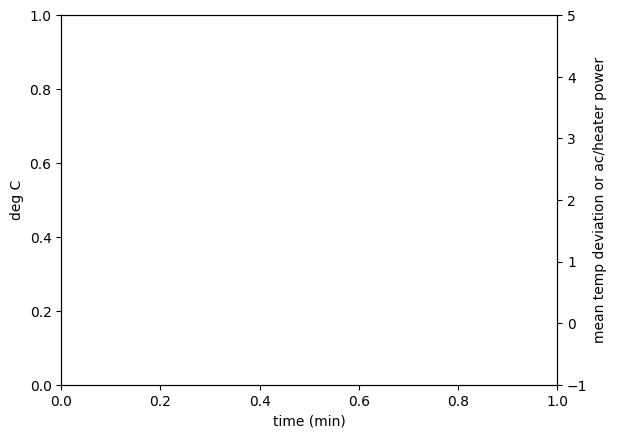

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import const
import random
import time
import agents.dumb_agent

fig, ax1 = plt.subplots()
ax1.set_xlabel("time (min)")
# ax1.set_ylim(10, 30)
# ax1.set_yticks(np.arange(10, 31))
ax1.set_ylabel("deg C")

ax2 = ax1.twinx()
ax2.set_ylim(-1, 5)
ax2.set_ylabel("mean temp deviation or ac/heater power")

sim_max = 2880

# weather_start = 695991
weather_start = random.randrange(0, len(const.OUTSIDE_TEMP) - sim_max)

xvalues = np.arange(0, sim_max)
temperatures = np.zeros(sim_max)
setpoints = np.zeros(sim_max)
outside_temp = np.zeros(sim_max)
on_off = np.zeros(sim_max)
mean_dev = np.zeros(sim_max)
old_action = 0
cycles = 0

deviation_sum = 0

state, _ = env.reset(num_setpoints=5, length=sim_max, start_time=weather_start)

for i in range(sim_max):	
	power = policy_net(torch.tensor([state])).max(1).indices.view(1, 1).item()
	# power = agents.dumb_agent.agent(env.get_cur_temp(), const.OUTSIDE_TEMP[weather_start + i], env.get_setpoint(), [-1, -0.75, -0.5, -0.25, 0, 1][old_action])
	# power = [-1, -0.75, -0.5, -0.25, 0, 1].index(power)
	if env._sgn(power) != env._sgn(old_action):
		cycles += 1
	old_action = power

	temperatures[i] = env.get_cur_temp()
	setpoints[i] = env.get_setpoint()
	outside_temp[i] = const.OUTSIDE_TEMP[weather_start + i]

	on_off[i] = env._actions[power]

	deviation_sum += abs(temperatures[i] - env.get_setpoint())
	state, reward, _ = env.step(power)

	mean_dev[i] = deviation_sum / (i + 1)

ax1.plot(xvalues, temperatures, color="red", linewidth=0.1)
ax1.plot(xvalues, setpoints, color="blue", linewidth=0.1)
ax1.plot(xvalues, outside_temp, color="green", linewidth=0.1)
ax2.plot(xvalues, on_off, color="black", linewidth=0.1)
ax2.plot(xvalues, mean_dev, color="purple", linewidth=0.1)
# plt.show()
plt.savefig("old2.png", dpi=1000)

cycles
# m2K/W * m2 * K

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import agents.dumb_agent
import const
import random
import time
import agents.pid_agent

fig, ax1 = plt.subplots()
ax1.set_ylabel("deg C")

# ax2 = ax1.twinx()
# ax2.set_ylabel("cycles")

episode_count = 100
sim_max = 2880
num_setpoints = 5

xvalues = np.arange(episode_count)
stupid_dev = np.zeros(episode_count)
stupid_cycles = np.zeros(episode_count)
dqn_dev = np.zeros(episode_count)
dqn_cycles = np.zeros(episode_count)

for i in range(episode_count):
	deviation_sum = 0
	# weather_start = 0
	weather_start = random.randrange(0, len(const.OUTSIDE_TEMP) - sim_max)
	state, _ = env.reset(num_setpoints=num_setpoints, length=sim_max, start_time=weather_start)
	old_action = 0
	cycles = 0
	for t in range(sim_max):	
		power = policy_net(torch.tensor([state])).max(1).indices.view(1, 1).item()
		if env._sgn(power) != env._sgn(old_action):
			cycles += 1
		old_action = power

		deviation_sum += abs(env.get_cur_temp() - env.get_setpoint())
		state, reward, _ = env.step(power)
	dqn_dev[i] = deviation_sum / sim_max
	dqn_cycles[i] = cycles
	print(f"{i + 1}/{episode_count}", end="\r")

print("             ", end="\r")
for i in range(episode_count):
	deviation_sum = 0
	# weather_start = 0
	weather_start = random.randrange(0, len(const.OUTSIDE_TEMP) - sim_max)
	state, _ = env.reset(num_setpoints=num_setpoints, length=sim_max, start_time=weather_start)
	old_action = 0
	cycles = 0
	for t in range(sim_max):	
		power = agents.dumb_agent.agent(env.get_cur_temp(), const.OUTSIDE_TEMP[weather_start + t], env.get_setpoint(), env._actions[old_action])
		power = env._actions.index(power)
		if env._sgn(power) != env._sgn(old_action):
			cycles += 1
		old_action = power

		deviation_sum += abs(env.get_cur_temp() - env.get_setpoint())
		state, reward, _ = env.step(power)
	stupid_dev[i] = deviation_sum / sim_max
	if deviation_sum / sim_max > 11:
		print("VERY BAD", weather_start)
	stupid_cycles[i] = cycles
	print(f"{i + 1}/{episode_count}", end="\r")

ax1.plot(xvalues, dqn_dev, linewidth=0.5, color="blue")
# ax2.plot(xvalues, dqn_cycles, linewidth=0.5, color="purple")
ax1.plot(xvalues, stupid_dev, linewidth=0.5, color="orange")
# ax2.plot(xvalues, stupid_cycles, linewidth=0.5, color="red")
plt.savefig("out.png", dpi=1000)

print(f"dqn dev mean {np.mean(dqn_dev)}")
print(f"dqn dev median {np.median(dqn_dev)}")
print(f"dqn dev min {np.min(dqn_dev)}")
print(f"dqn dev max {np.max(dqn_dev)}")

print(f"dqn cycle mean {np.mean(dqn_cycles)}")
print(f"dqn cycle median {np.median(dqn_cycles)}")
print(f"dqn cycle min {np.min(dqn_cycles)}")
print(f"dqn cycle max {np.max(dqn_cycles)}")

print(f"stupid dev mean {np.mean(stupid_dev)}")
print(f"stupid dev median {np.median(stupid_dev)}")
print(f"stupid dev min {np.min(stupid_dev)}")
print(f"stupid dev max {np.max(stupid_dev)}")

print(f"stupid cycle mean {np.mean(stupid_cycles)}")
print(f"stupid cycle median {np.median(stupid_cycles)}")
print(f"stupid cycle min {np.min(stupid_cycles)}")
print(f"stupid cycle max {np.max(stupid_cycles)}")

# m2K/W * m2 * K

In [ ]:
pytorch_total_params = sum(p.numel() for p in policy_net.parameters() if p.requires_grad)
pytorch_total_params